# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 : Jungwoo Kim
- 기수 : 11th



## 해당 과제에는 6개의 섹션과 7개의 문제가 있습니다! 누락없이 제출 부탁드립니다 :)

In [1]:
# 이번 과제의 일부였던 CustomDataset.py, Model.py를 로드해주세요
from CustomDataset import CustomImageDataset
from Model import ResNet50

import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# config.yaml의 위치를 지정해주세요
config_path = "./config.yaml"

# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [3]:
# config.yaml에서 디렉토리, 모델 하이퍼파라미터를 각각 받아옵니다
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

dataset_direc, meta_direc, weight_direc \
    = config["Direc"]["DatasetDirec"], \
      config["Direc"]["MetaDataDirec"], \
      config["Direc"]["WeightDirec"]

epoch, batch_size, lr \
    = config["HyperParameters"]["Epoch"], \
      config["HyperParameters"]["BatchSize"], \
      float(config["HyperParameters"]["LearningRate"]) # config.yaml에서 이미 float 자료형으로 학습률을 정의하신 분은 float()으로 자료형 변환을 하지 않으셔도 됩니다.

In [4]:
print(epoch)
print(batch_size)
print(lr)

120
64
0.001


In [7]:
import wandb # wandb.ai으로의 실시간 연동을 위한 라이브러리 임포트
from signal import signal, SIGPIPE, SIG_DFL
#Ignore SIG_PIPE and don't throw exceptions on it... (http://docs.python.org/library/signal.html)
signal(SIGPIPE,SIG_DFL)

# wandb login
wandb.init(
    project="DSL_ResNet", entity="kjungwoo03",
    name="experiment_4",
    config={
        "model_name": "ResNet",
        "epochs": epoch,
        "batch_size": batch_size,
        "lr": lr
    })

config = wandb.config

In [8]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. train, val, test DataLoader 초기화

### 문제 1. 
모델의 학습을 train, validation, test로 나눠서 진행하는 이유는 무엇인가요? 

A. overfitting 방지

### 문제 2. 
모델의 generalization을 높여주기 위해 Augmentation을 사용할 수 있다고 했습니다. 

PyTorch 구현상으로는 train, validation, test 모든 단계에 Augmention를 구현할 수 있습니다만, 실제로는 특정 단계에서만 Augmention를 수행하게 됩니다. 어느 단계에서 RandAugment가 적용되어야하는지와, 그 이유에 대해서 설명해주세요.

A. Train 단계에서만 적용하나, 데이터 수 등 경우에 따라 val 단계에도 적용하기도 함. augmentation 자체가 다양한 input에 대한 model을 학습시키며, 충분한 양의 train data를 확보하는데 있기 때문.

### 문제 3. 
CustomImageDataset과 DataLoader 클래스의 차이점에 대해서 설명해주세요.
- (힌트 : 두 클래스의 리턴 형식에 어떤 차이가 있나요? 어디서부터 Batch 단위로 리턴되나요?)

A. CustomImageDataset이 각각의 image raw data를 들고와서 DataLoader에 넣어주게 됨.

In [9]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv('./MetaData.csv')

# train : val : test = 6 : 2 : 2
train, val_temp = train_test_split(meta_data, train_size=0.6, random_state=777)
val, test = train_test_split(val_temp, train_size=0.5, random_state=777)

# Model generalization을 위해 RandomAugmentation에 어떤 변형을 가할 지 transforms.Compose([])로 묶어놓읍시다
train_transforms = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.75, 1.3333333333333333)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ColorJitter(brightness=[0.5, 1.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df=train, transform=train_transforms)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df=val, transform=train_transforms)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df=test, transform=train_transforms)


train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)

# 3. 모델 초기화, 손실함수 및 optimizer 지정

### 문제 4. 

주어진 과제는 Binary Classification 태스크입니다. 

이중 분류를 위해서는 손실함수로 Binary Cross Entropy를 사용한다고 세션에서 배웠습니다.

PyTorch에는 Binary Cross Entropy를 학습에 사용할 수 있는 2가지 방법이 있는데요, 'nn.BCELoss'와 'nn.BCEWithLogitsLoss'입니다. 

이 둘은 같아 보이지만 구현상에서 명백한 차이점이 있습니다.

이 둘의 차이점에 대해서 서술해주세요.

A. input으로 넣어주는 값이 sigmoid를 통과하기 전의 logit이라는 점에서 그 차이가 있음.

In [10]:
# model을 선언하고 GPU에 올려줍니다
model = ResNet50()
model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [11]:
from torchsummary import summary

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 256, 56, 56]          16,384
       BatchNorm2d-6          [-1, 256, 56, 56]             512
            Conv2d-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
from torchvision.models import resnet50

resnet_pretrained = resnet50().cuda()
summary(resnet_pretrained, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
# 손실함수를 정의해주세요 
criterion = nn.BCEWithLogitsLoss()
# optimizer를 정의해주세요 
optimizer = torch.optim.Adam(model.parameters(), lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

### 문제 5. 
학습이 끝난 이후 val_loss, train_loss 변화 추이 그래프와 val_acc, train_acc 변화 추이 그래프를 첨부해주세요.
(wandb 대시보드에서 캡쳐하셔도 됩니다)

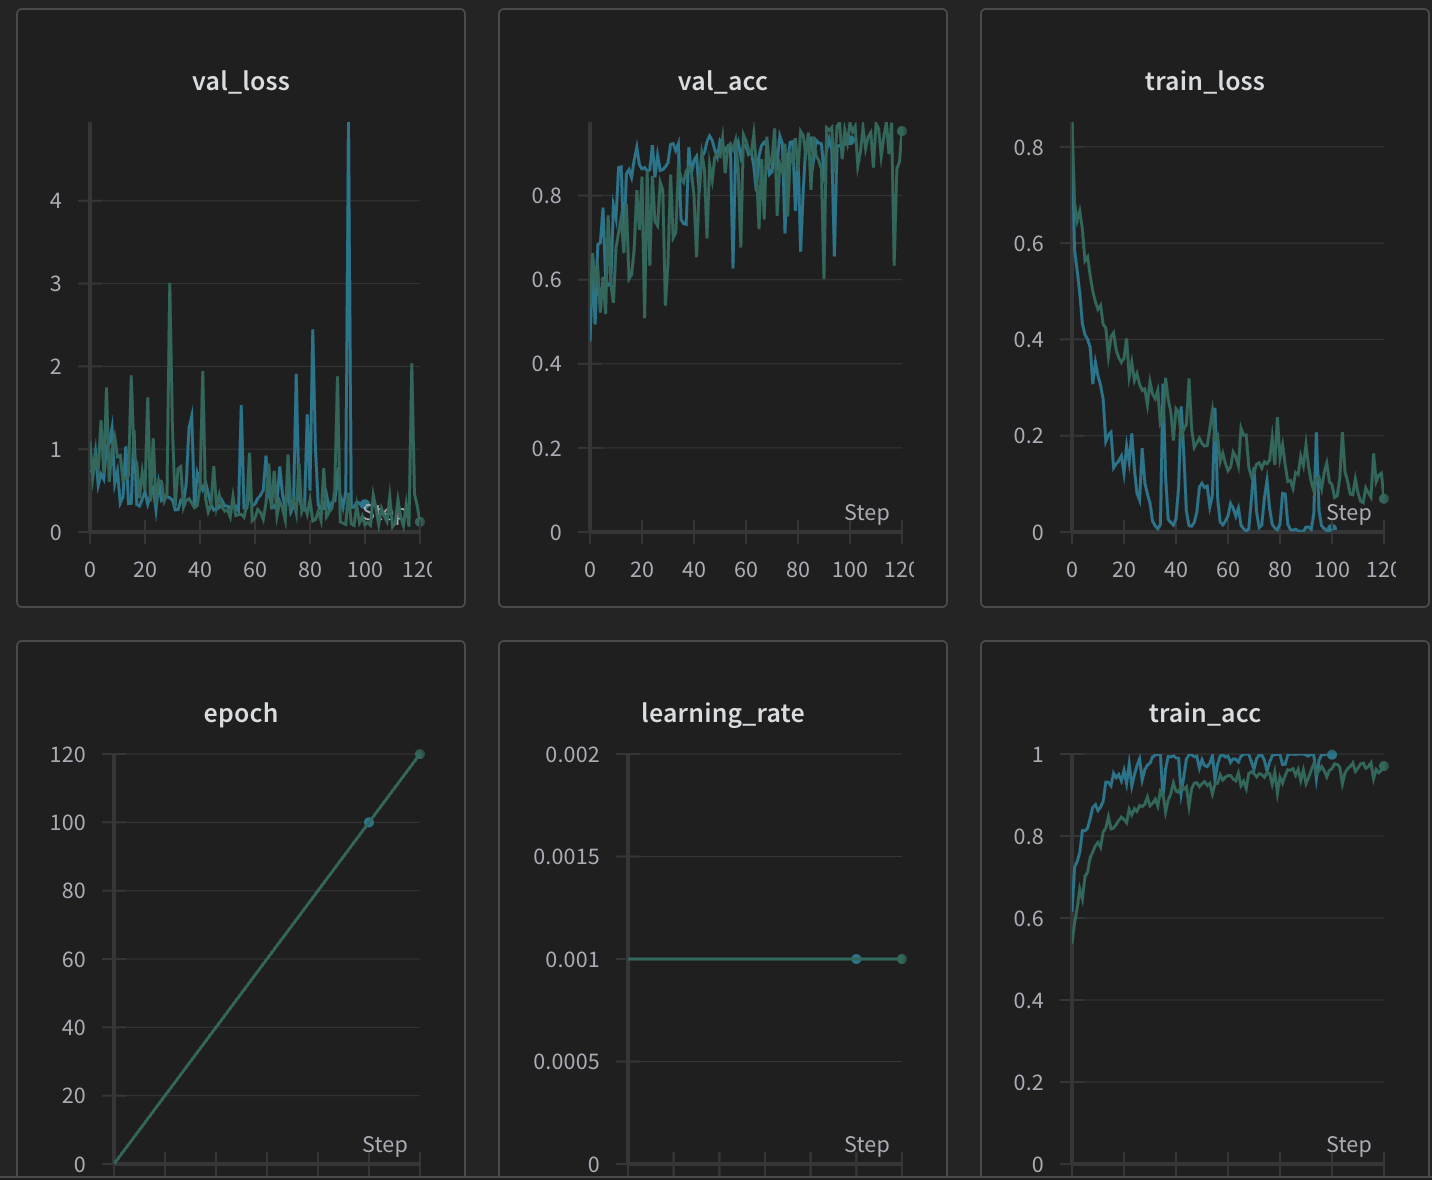

In [14]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")

# Training, Validation 시작
for curr_epoch in range(epoch + 1):  # iterate over all EPOCHS
    train_loss = 0
    correct_train = 0
    total_train = 0  # 총 학습 데이터 수를 계산하기 위한 변수
    
    print("")
    model.train()  # 모델을 학습 모드로 설정
    for img, label in train_loader:  # iterate over all BATCHES
        img, label = img.to(device), label.to(device)  # GPU에 데이터 올리기
        pred = model(img)  # Forward Propagation

        label = label.view(-1, 1).float()  # 목표 텐서의 모양 조정
        loss = criterion(pred, label)  # 손실함수 계산

        optimizer.zero_grad()  # 누적된 기울기 초기화
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        train_loss += loss.item()  # 해당 Batch에서의 loss 누적

        pred_class = (torch.sigmoid(pred) > 0.5).float()  # 이진 분류를 위한 임계값 적용
        correct_train += (pred_class == label).float().sum()  # 정확도 계산
        total_train += label.size(0)

    train_loss /= len(train_loader)  # 평균 학습 손실
    train_acc = correct_train / total_train  # 평균 학습 정확도

    # Validation 시작
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0
    correct_val = 0
    total_val = 0  # 총 검증 데이터 수를 계산하기 위한 변수
    with torch.no_grad():  # 기울기 계산을 하지 않음
        for img, label in val_loader:
            img, label = img.to(device), label.to(device)
            pred = model(img)
            label = label.view(-1, 1).float()

            loss = criterion(pred, label)  # 손실함수 계산
            val_loss += loss.item()  # 해당 Batch에서의 loss 누적

            pred_class = (torch.sigmoid(pred) > 0.5).float()  # 이진 분류를 위한 임계값 적용
            correct_val += (pred_class == label).float().sum()  # 정확도 계산
            total_val += label.size(0)

    val_loss /= len(val_loader)  # 평균 검증 손실
    val_acc = correct_val / total_val  # 평균 검증 정확도

    print(f"Epoch {curr_epoch}/{epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    metrics = {
        "epoch": curr_epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc.item(),
        "val_acc": val_acc.item(),
        "learning_rate": lr
    }

    wandb.log(metrics)

    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt"))

wandb.finish()


Epoch 0/120, Train Loss: 0.8516, Train Acc: 0.5372, Val Loss: 1.0915, Val Acc: 0.5350

Epoch 1/120, Train Loss: 0.6828, Train Acc: 0.5883, Val Loss: 0.6544, Val Acc: 0.6633

Epoch 2/120, Train Loss: 0.6465, Train Acc: 0.6244, Val Loss: 0.9138, Val Acc: 0.5917

Epoch 3/120, Train Loss: 0.6668, Train Acc: 0.6706, Val Loss: 0.7444, Val Acc: 0.6250

Epoch 4/120, Train Loss: 0.6279, Train Acc: 0.6461, Val Loss: 1.3505, Val Acc: 0.5217

Epoch 5/120, Train Loss: 0.5635, Train Acc: 0.7017, Val Loss: 0.7093, Val Acc: 0.6067

Epoch 6/120, Train Loss: 0.5714, Train Acc: 0.7117, Val Loss: 1.7439, Val Acc: 0.5183

Epoch 7/120, Train Loss: 0.5322, Train Acc: 0.7478, Val Loss: 0.6055, Val Acc: 0.7533

Epoch 8/120, Train Loss: 0.5001, Train Acc: 0.7611, Val Loss: 0.9986, Val Acc: 0.5900

Epoch 9/120, Train Loss: 0.4783, Train Acc: 0.7767, Val Loss: 1.1485, Val Acc: 0.5450

Epoch 10/120, Train Loss: 0.4622, Train Acc: 0.7844, Val Loss: 0.9078, Val Acc: 0.6767

Epoch 11/120, Train Loss: 0.4709, Train A

# 5. Test

학습이 모두 끝났다면, 가장 낮은 validation loss를 기록한 모델의 파라미터를 불러오도록합시다.

이후에는 confusion matrix, accuracy 등을 측정하여 모델이 얼마나 잘 학습되었는지 평가하도록 하겠습니다.

### 문제6. 

accuracy 95% 이상이 되도록 학습률 등을 조절해주세요.

In [15]:
trained_model = ResNet50() # 우선 ResNet50 모델 하나를 초기화 해줍니다
trained_model.load_state_dict(torch.load(os.path.join(weight_direc, "best_model(aug).pt"))) # 아까 저장해둔 weight를 로드해줍니다
trained_model.eval() # 모델을 evaluation 모드로 설정합니다
trained_model.to(device) 

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

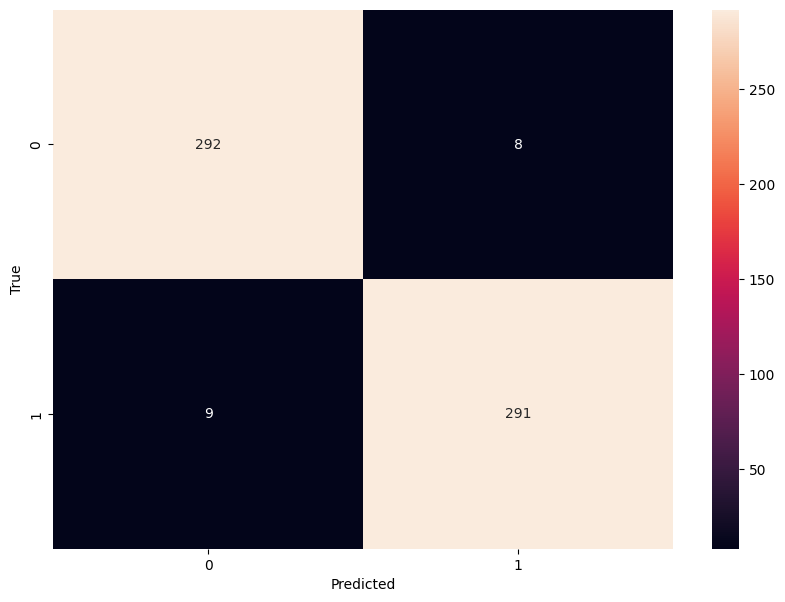

Accuracy: 97.17%


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

all_labels = []
all_predictions = []

for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    
    with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
        pred = trained_model(image) # 순전파

        probabilities = torch.sigmoid(pred) # 시그모이드 함수를 이용해 확률을 계산합니다
        predicted = (probabilities > 0.5).float()  # 확률을 label로 바꿔줍니다

        all_labels.extend(label.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Confusion matrix를 그려줍니다
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy도 출력해봅시다
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# 6. Augmentation vs No Augmentation 

### 문제 7. 

전달받으신 파일들 중, Run_NoAugment.ipynb라는 파일이 있을 겁니다.

지금 보고 계신 노트북과 똑같이 학습을 시키시되, 이번에는 학습 시 data augmentation을 적용시키지 않고 진행하십시오.

이후 augmentation을 적용시키지 않은 모델의 train loss와 val loss의 차트를 아래에 붙여놓으시고, 

augmentation을 적용한 모델의 학습 양상과 어떤 점이 다른 지와 그 이유도 함께 설명해주세요.

overfitting 예방이나 train dataset의 크기 차이로 인해 acc 차이가 발생하는 것 같음

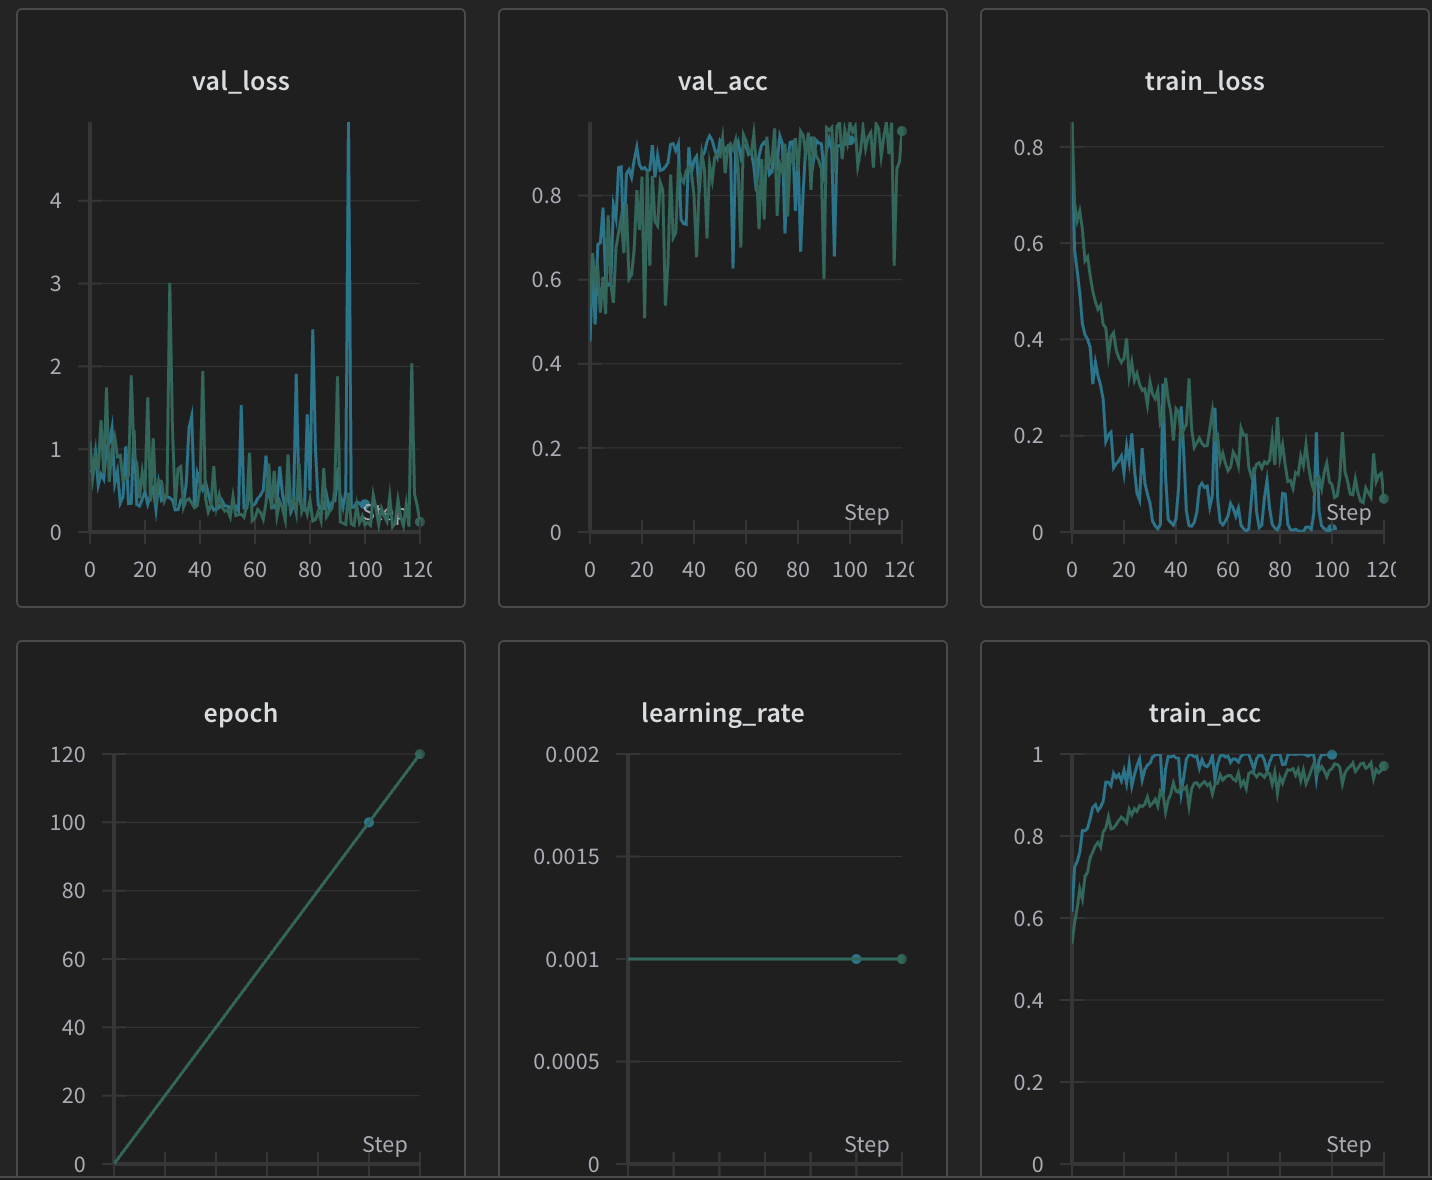